<p style="color:red;font-size:32px;text-align:center"> <b>Social Network Graph Link Prediction : Part 1</b> </p>

## <font color='blue'>Table of contents</font>
#### 1. Business Task
#### 2. Mapping the task to ML 
#### 3. Exploratory Data Analysis
#### 4. ML Formulation
#### 5. Feature Engineering
#### 6. Building Train and Test data sets
#### 7. ML Modelling
#### 8. Conclusion

# 1. Business Task

## 1.1 Problem Statement
* <font color='blue'> Given a directed social graph, predict the missing links to recommend friends/connnections/followers (Link Prediction in graph). </font>

## 1.2 Business Objectives and Constraints

* No latency requirements as we don't have to predict the link right away.

* Model Interpretation is not mandatory

* Predicting the probability of a link so as to recommend the highest probable link to a user<br>
if the number of recommendations is high else we'll ignore this constraint.

* We want our model to have high precision and high recall.

# 2. Mapping the task to ML 

## 2.1 Data Overview

* Download dataset from [Facebook's recruiting challenge on Kaggle](https://www.kaggle.com/c/FacebookRecruiting)

* The dataset contains 9.43 million entries. Each entry is a directed link/edge between two users.

* The dataset contains two columns.
    - <font color='blue'> source_node ==> user_i (dtype : int64) </font>
    - <font color='blue'>destination_node  ==> user_j (dtype : int64) </font>
    
    
* Each row contains two entries indicating presence of directed edge/link between the source_node(user_i) and destination_node(user_j).

* <font color='blue'>The given data is a directed graph, ie,. u_i --> u_j is different from u_i <-- u_j.</font>

## 2.2 ML problem formulation

* This task of predicting links/edges between two users can be posed as a binary classification task.
    - <font color='blue'> label 0 implies the absence of edge/link of user_i and user_j </font>
    - <font color='blue'> label 1 implies the presence of edge/link of user_i and user_j </font>

## 2.3 Performance Metrics

* We want our model to have high precision and high recall. Hence F1_Score is the appropriate choice.

* We'll also use confusion matrix and accuracy score.

* We'll also use the log_loss score as determine the uncertainity between the models.

## 2.4 References

* [The Link Prediction Problem for Social Networks](https://www.cs.cornell.edu/home/kleinber/link-pred.pdf)
* [New Perspectives and Methods in Link Prediction](https://www3.nd.edu/~dial/publications/lichtenwalter2010new.pdf)
* [Kaggle Forum](https://kaggle2.blob.core.windows.net/forum-message-attachments/2594/supervised_link_prediction.pdf)
* [Network Analysis. Lecture 18. Link prediction](https://www.youtube.com/watch?v=2M77Hgy17cg)

# 3. Exploratory Data Analysis

In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
import networkx as nx
import pickle
import gc
from collections import defaultdict
from sklearn.model_selection import train_test_split

__LOADING THE DATA__

In [2]:
graph_df = pd.read_csv('graph.csv')
graph_df.head(5)

,source_node,destination_node
0,1,690569
1,1,315892
2,1,189226
3,2,834328
4,2,1615927


In [3]:
print(f"Number of entries(edges/links) in graph_df : {len(graph_df)}")
print(f"Number of null values in graph_df          : {graph_df.isna().any(1).sum()}")
print(f"Number of duplicates in graph_df           : {graph_df.duplicated().sum()}")

Number of entries(edges/links) in graph_df : 9437519
Number of null values in graph_df          : 0
Number of duplicates in graph_df           : 0


In [4]:
graph_file_path = 'processed/after_eda/graph_wo_header.csv'

if not os.path.exists(graph_file_path):
    #save the train_df as csv to load it in a graph
    graph_df.to_csv(graph_file_path, header=False, index=False)
    print(f"Saved train.csv at directory : {graph_file_path}")
else:
    print(f"file already exists at directory : {graph_file_path}")

Saved train.csv at directory : processed/after_eda/graph_wo_header.csv


__LOADING THE CSV FILE AS A GRAPH__

* __<font color='green'>The csv file provided contains source_destination_pairs in each line which have an link.</font>__
* __<font color='green'>All the source_destination_pairs from the csv file can be considered as source node connected to destination_node.</font>__
* __<font color='green'> We can represent the whole csv file as a graph which has nodes with egdes/links between them indicating they are connected. </font>__

In [5]:
graph = nx.read_edgelist(graph_file_path, delimiter=',', create_using=nx.DiGraph(), nodetype=int)
print(nx.info(graph))

Name: 
Type: DiGraph
Number of nodes: 1862220
Number of edges: 9437519
Average in degree:   5.0679
Average out degree:   5.0679


>  * __<font color='green'> There are 1.86 million unique nodes(users) in the graph. </font>__
>  * __<font color='green'> There are 9.43 million edges(connections) between 1.86 million users. </font>__
>  * __<font color='green'> Average in_degree(#users that follow the user) and Average out_degree(#users followed by the user) are 5. </font>__

__DISPLAYING A SUB_GRAPH__

Name: 
Type: DiGraph
Number of nodes: 66
Number of edges: 50
Average in degree:   0.7576
Average out degree:   0.7576


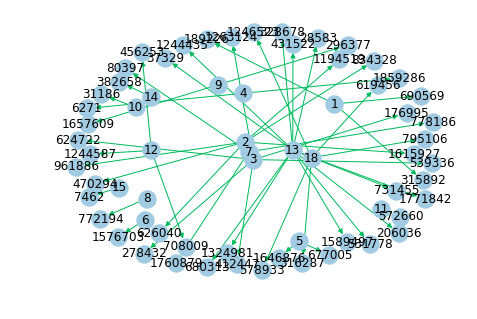

In [7]:
sub_graph_file_path = 'processed/after_eda/sub_graph_wo_header.csv'

if not os.path.exists(sub_graph_file_path):
    pd.read_csv('data/graph.csv', nrows=50).to_csv(sub_graph_file_path, index=False, header=False)

    
sub_graph = nx.read_edgelist(sub_graph_file_path, delimiter=',', create_using=nx.DiGraph(), nodetype=int)
# https://stackoverflow.com/questions/9402255/drawing-a-huge-graph-with-networkx-and-matplotlib
pos = nx.spring_layout(sub_graph)
nx.draw(sub_graph, pos, node_color='#A0CBE2', edge_color='#00bb5e', width=1, edge_cmap=plt.cm.Blues, with_labels=True)
plt.savefig("graph_sample.pdf")
print(nx.info(sub_graph))

## 3.1 Number of users who follow a user(followers)

In [8]:
in_degree_vals = np.array(list(dict(graph.in_degree()).values()))
in_degree_vals_sorted = sorted(in_degree_vals)

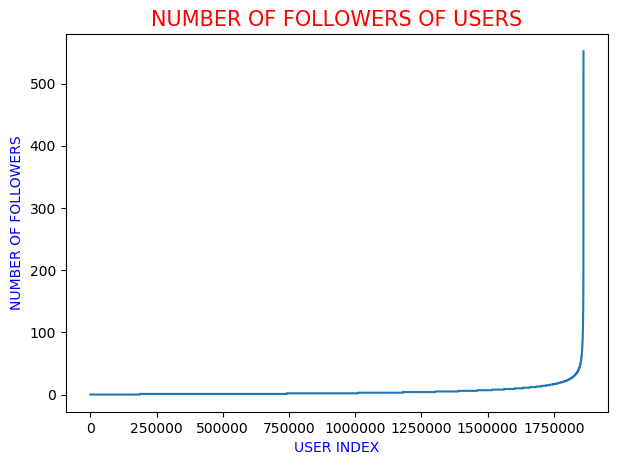

In [9]:
plt.figure(figsize=(7, 5), dpi=100)
plt.plot(in_degree_vals_sorted)
plt.xlabel('USER INDEX', color='b')
plt.ylabel('NUMBER OF FOLLOWERS', color='b')
plt.title('NUMBER OF FOLLOWERS OF USERS', fontsize=15, color='r')
plt.show()

> * The graph is totally skewed, let's zoom in.

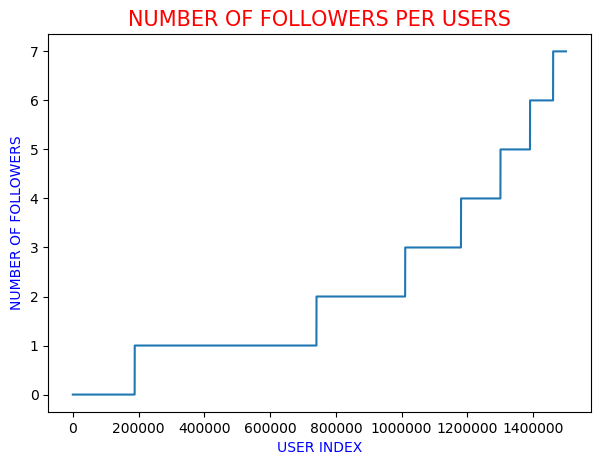

In [10]:
plt.figure(figsize=(7, 5), dpi=100)
plt.plot(in_degree_vals_sorted[:1500000])
plt.xlabel('USER INDEX', color='b')
plt.ylabel('NUMBER OF FOLLOWERS', color='b')
plt.title('NUMBER OF FOLLOWERS PER USERS', fontsize=15, color='r')
plt.show()

In [11]:
print(f"Number of users having zero followers : {(in_degree_vals == 0).sum()}")

Number of users having zero followers : 188043


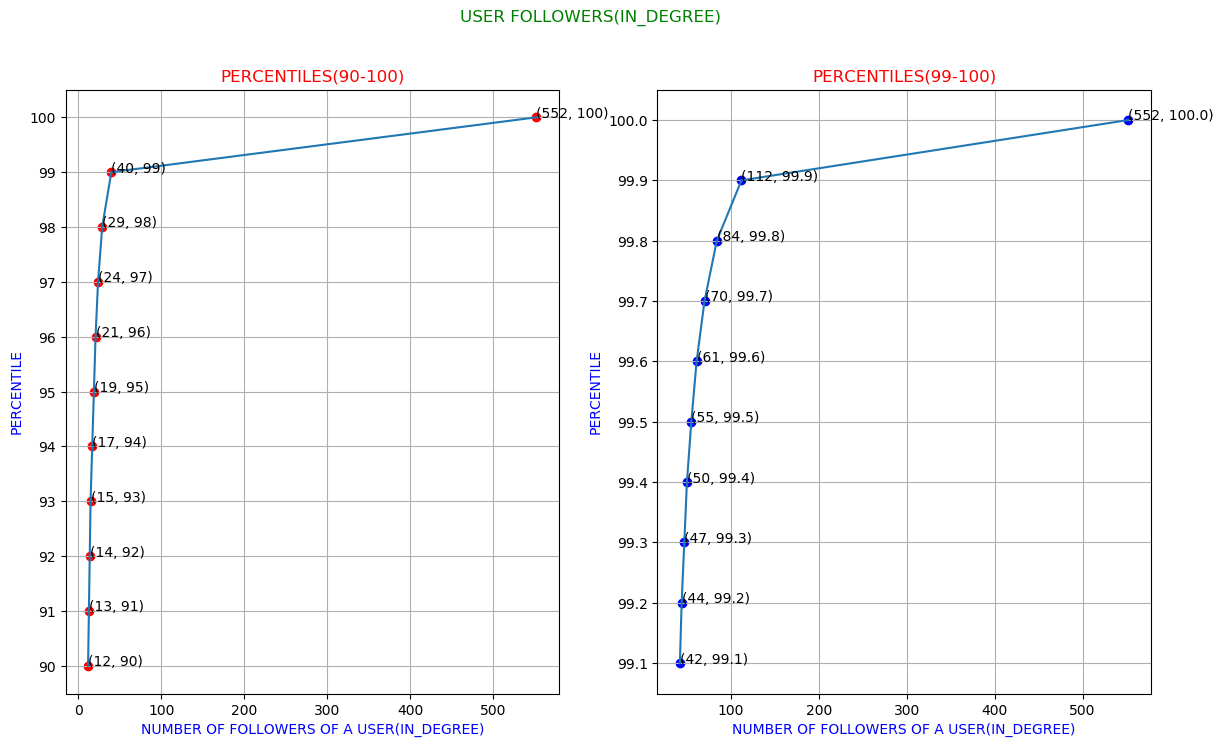

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 8), dpi=100)
fig.suptitle('USER FOLLOWERS(IN_DEGREE)', color='g')

percentiles90 = np.arange(90, 101)
in_degree_percentiles90 = np.percentile(in_degree_vals_sorted, percentiles90).astype(np.int)

ax1.scatter(in_degree_percentiles90, percentiles90, c='r')
ax1.plot(in_degree_percentiles90, percentiles90)
ax1.set_yticks(percentiles90)
ax1.set_ylabel('PERCENTILE', color='b')
ax1.set_xlabel('NUMBER OF FOLLOWERS OF A USER(IN_DEGREE)', color='b')
ax1.set_title('PERCENTILES(90-100)', color='r')
ax1.grid()

for i, p in zip(in_degree_percentiles90, percentiles90):
    ax1.annotate(s=f"({i}, {p})", xy=(i, p))


percentiles99 = np.round(np.arange(99.1, 100.1, 0.1), 1)
in_degree_percentiles99 = np.percentile(in_degree_vals_sorted, percentiles99).astype(np.int)

ax2.scatter(in_degree_percentiles99, percentiles99, c='b')
ax2.plot(in_degree_percentiles99, percentiles99)
ax2.set_yticks(percentiles99)
ax2.set_ylabel('PERCENTILE', color='b')
ax2.set_xlabel('NUMBER OF FOLLOWERS OF A USER(IN_DEGREE)', color='b')
ax2.set_title('PERCENTILES(99-100)', color='r')
ax2.grid()

for i, p in zip(in_degree_percentiles99, percentiles99):
    ax2.annotate(s=f"({i}, {p})", xy=(i, p))

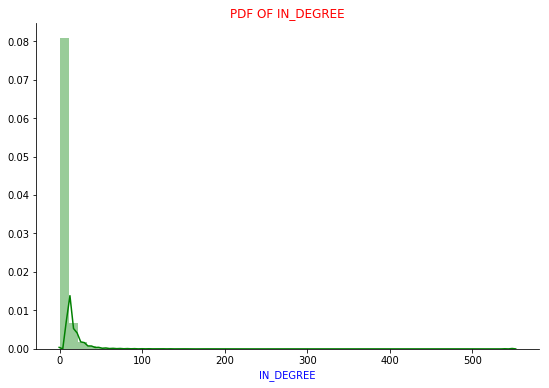

In [13]:
plt.figure(figsize=(9, 6))
sns.distplot(in_degree_vals_sorted, color='g')
plt.xlabel('IN_DEGREE', color='b')
plt.title('PDF OF IN_DEGREE' , color='r')
sns.despine()
plt.show()

__<font color='green'> OBSERVATIONS </font>__

* There are 188K (10%) users who aren't followed by any user.
* 99% of users have 40 or fewer followers.

## 3.2 Number of users followed by a user(followees)

In [14]:
out_degree_vals = np.array(list(dict(graph.out_degree()).values()))
out_degree_vals_sorted = sorted(out_degree_vals)

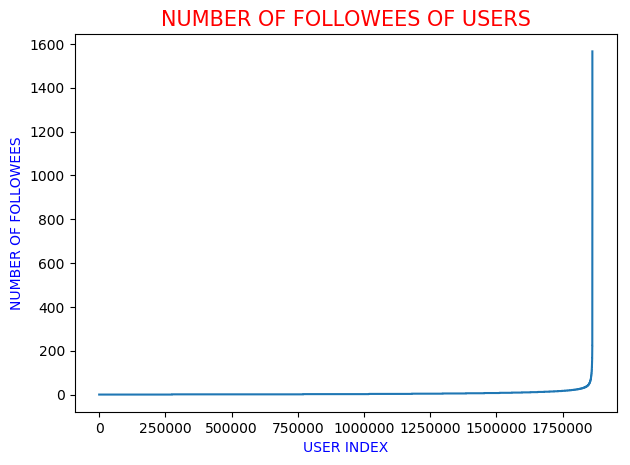

In [15]:
plt.figure(figsize=(7, 5), dpi=100)
plt.plot(out_degree_vals_sorted)
plt.xlabel('USER INDEX', color='b')
plt.ylabel('NUMBER OF FOLLOWEES', color='b')
plt.title('NUMBER OF FOLLOWEES OF USERS', fontsize=15, color='r')
plt.show()

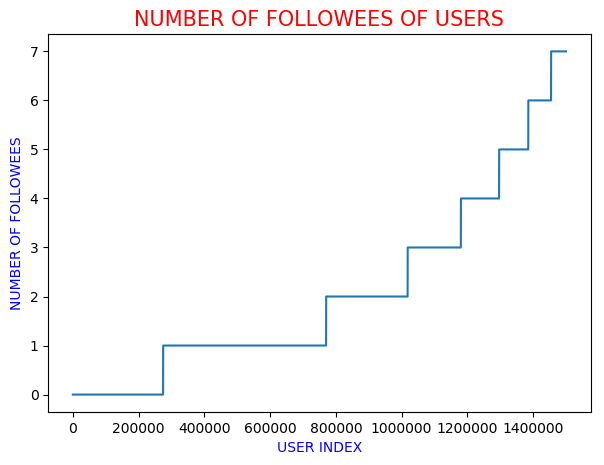

In [16]:
plt.figure(figsize=(7, 5), dpi=100)
plt.plot(out_degree_vals_sorted[:1500000])
plt.xlabel('USER INDEX', color='b')
plt.ylabel('NUMBER OF FOLLOWEES', color='b')
plt.title('NUMBER OF FOLLOWEES OF USERS', fontsize=15, color='r')
plt.show()

In [17]:
print(f"Number of users who don't follow anyone : {(out_degree_vals == 0).sum()}")

Number of users who don't follow anyone : 274512


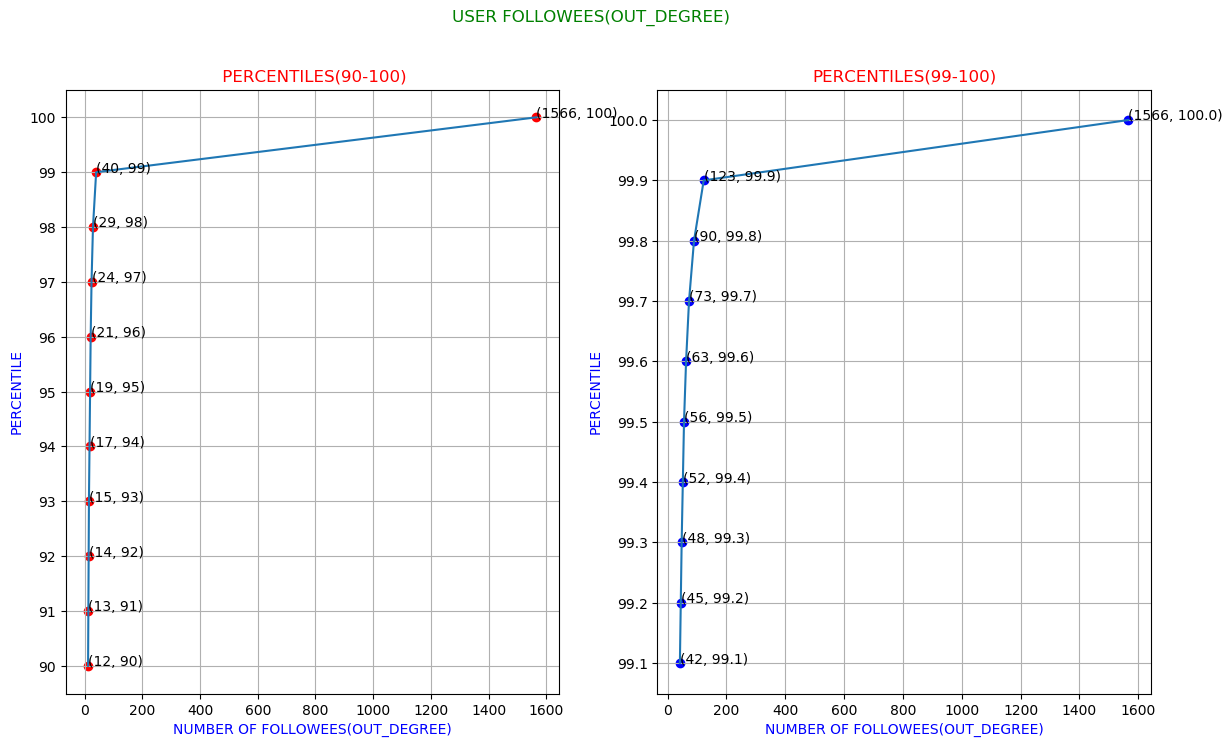

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 8), dpi=100)
fig.suptitle('USER FOLLOWEES(OUT_DEGREE)', color='g')

percentiles90 = np.arange(90, 101)
out_degree_percentiles90 = np.percentile(out_degree_vals_sorted, percentiles90).astype(np.int)

ax1.scatter(out_degree_percentiles90, percentiles90, c='r')
ax1.plot(out_degree_percentiles90, percentiles90)
ax1.set_yticks(percentiles90)
ax1.set_ylabel('PERCENTILE', color='b')
ax1.set_xlabel('NUMBER OF FOLLOWEES(OUT_DEGREE)', color='b')
ax1.set_title(' PERCENTILES(90-100)', color='r')
ax1.grid()

for o, p in zip(out_degree_percentiles90, percentiles90):
    ax1.annotate(s=f"({o}, {p})", xy=(o, p))


percentiles99 = np.round(np.arange(99.1, 100.1, 0.1), 1)
out_degree_percentiles99 = np.percentile(out_degree_vals_sorted, percentiles99).astype(np.int)

ax2.scatter(out_degree_percentiles99, percentiles99, c='b')
ax2.plot(out_degree_percentiles99, percentiles99)
ax2.set_yticks(percentiles99)
ax2.set_ylabel('PERCENTILE', color='b')
ax2.set_xlabel('NUMBER OF FOLLOWEES(OUT_DEGREE)', color='b')
ax2.set_title('PERCENTILES(99-100)', color='r')
ax2.grid()

for o, p in zip(out_degree_percentiles99, percentiles99):
    ax2.annotate(s=f"({o}, {p})", xy=(o, p))

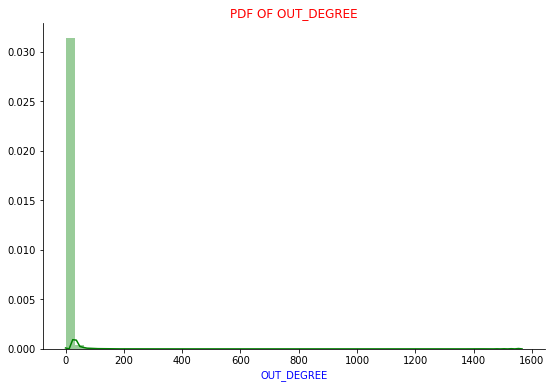

In [19]:
plt.figure(figsize=(9, 6))
sns.distplot(out_degree_vals_sorted, color='g')
plt.xlabel('OUT_DEGREE', color='b')
plt.title('PDF OF OUT_DEGREE' , color='r')
sns.despine()
plt.show()

__<font color='green'> OBSERVATIONS </font>__

* There are 275K (15%) users who don't follow any of the users.
* 99% of users have atleast follow 40 or fewer users.

## 3.3 Number of followers + Number of followees of a user

In [20]:
users_with_zero_ff = len(set(np.where(out_degree_vals == 0)[0]) & set(np.where(in_degree_vals == 0)[0]))
print(f"Number of users who neither have followers nor follow anyone : {users_with_zero_ff}")

Number of users who neither have followers nor follow anyone : 0


> * <font color='red'>That was obvious beacause an entry in the dataset assures some property to a user.</font>

In [21]:
in_out_degree_vals = in_degree_vals + out_degree_vals
in_out_degree_vals_sorted = sorted(in_out_degree_vals)

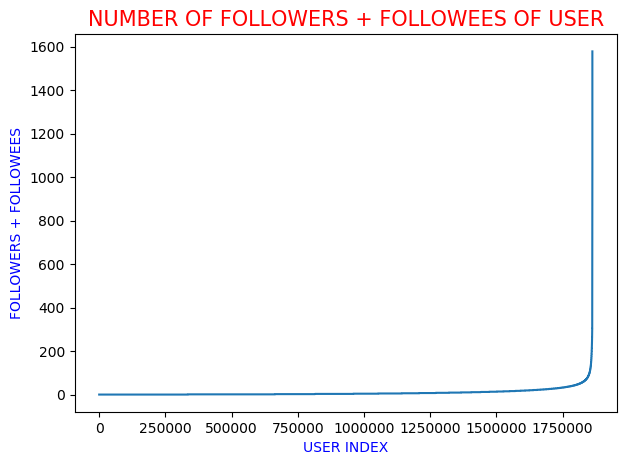

In [22]:
plt.figure(figsize=(7, 5), dpi=100)
plt.plot(in_out_degree_vals_sorted)
plt.xlabel('USER INDEX', color='b')
plt.ylabel('FOLLOWERS + FOLLOWEES', color='b')
plt.title('NUMBER OF FOLLOWERS + FOLLOWEES OF USER', fontsize=15, color='r')
plt.show()

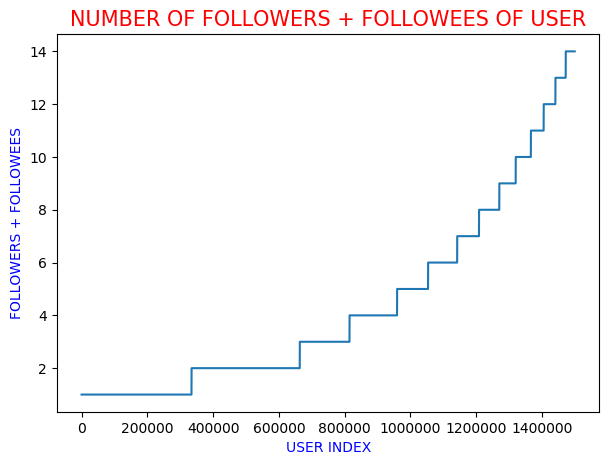

In [23]:
plt.figure(figsize=(7, 5), dpi=100)
plt.plot(in_out_degree_vals_sorted[:1500000])
plt.xlabel('USER INDEX', color='b')
plt.ylabel('FOLLOWERS + FOLLOWEES', color='b')
plt.title('NUMBER OF FOLLOWERS + FOLLOWEES OF USER', fontsize=15, color='r')
plt.show()

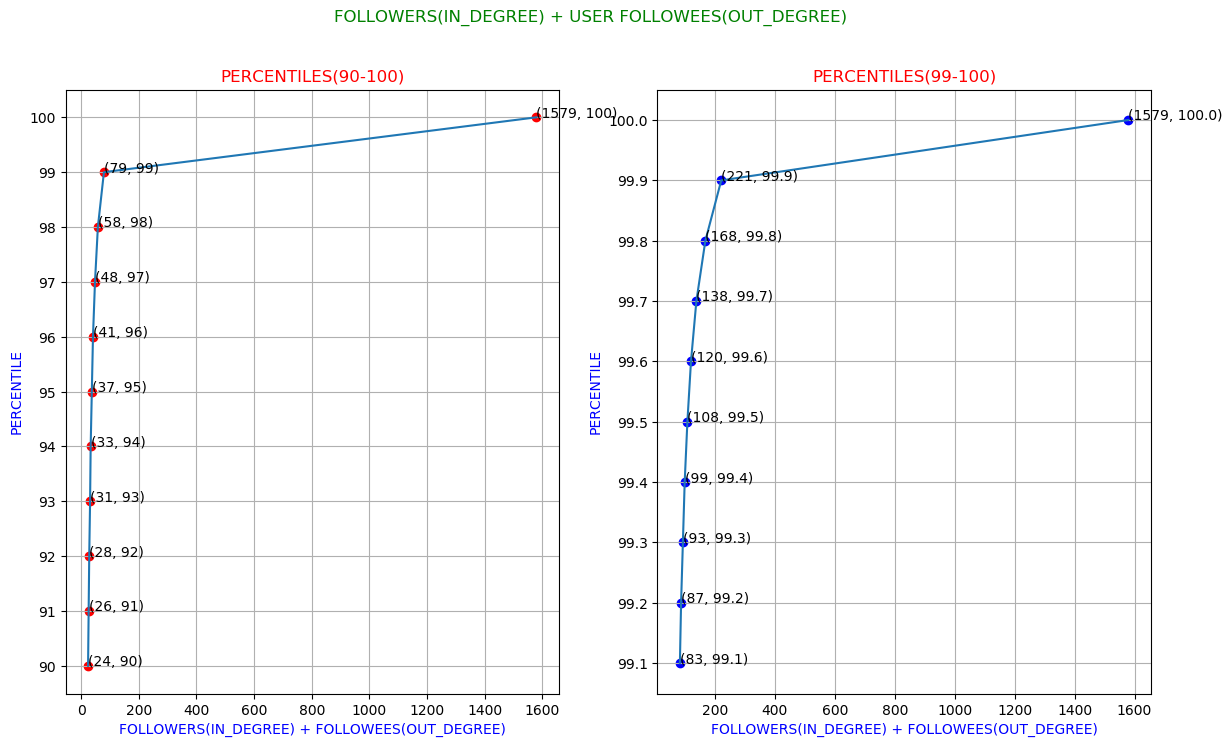

In [24]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 8), dpi=100)
fig.suptitle('FOLLOWERS(IN_DEGREE) + USER FOLLOWEES(OUT_DEGREE)', color='g')

percentiles90 = np.arange(90, 101)
in_out_degree_percentiles90 = np.percentile(in_out_degree_vals_sorted, percentiles90).astype(np.int)

ax1.scatter(in_out_degree_percentiles90, percentiles90, c='r')
ax1.plot(in_out_degree_percentiles90, percentiles90)
ax1.set_yticks(percentiles90)
ax1.set_ylabel('PERCENTILE', color='b')
ax1.set_xlabel('FOLLOWERS(IN_DEGREE) + FOLLOWEES(OUT_DEGREE)', color='b')
ax1.set_title('PERCENTILES(90-100)', color='r')
ax1.grid()

for o, p in zip(in_out_degree_percentiles90, percentiles90):
    ax1.annotate(s=f"({o}, {p})", xy=(o, p))


percentiles99 = np.round(np.arange(99.1, 100.1, 0.1), 1)
in_out_degree_percentiles99 = np.percentile(in_out_degree_vals_sorted, percentiles99).astype(np.int)

ax2.scatter(in_out_degree_percentiles99, percentiles99, c='b')
ax2.plot(in_out_degree_percentiles99, percentiles99)
ax2.set_yticks(percentiles99)
ax2.set_ylabel('PERCENTILE', color='b')
ax2.set_xlabel('FOLLOWERS(IN_DEGREE) + FOLLOWEES(OUT_DEGREE)', color='b')
ax2.set_title('PERCENTILES(99-100)', color='r')
ax2.grid()

for o, p in zip(in_out_degree_percentiles99, percentiles99):
    ax2.annotate(s=f"({o}, {p})", xy=(o, p))

__<font color='green'> OBSERVATIONS </font>__

* 99% of users have atleast 79 or fewer edges/links.
* Any user in the graph has atleast one edge/link. ie., there are no users having (in_degree + out_degree = 0)

## 3.4 Number of users who follow back(u1 <--> u2)

* let's find out how many of the users follow back. ie,. u1 follows u2 and vice versa.
* This property is called __parallel edges__ in graph theory.
* The above code snippet returns a dict with key being user_i and values being users who follow back user_.
* As we iterate over each user_i if u1 <--> u2, (u1 --> u2 and u2 --> u1) are stored.

In [25]:
%%time

parallel_edges = defaultdict(lambda : [])

for predecessor in list(set(graph.nodes)):
    try:
        for successor in list(graph.neighbors(predecessor)):
            if predecessor in list(graph.neighbors(successor)):
                parallel_edges[predecessor].append(successor)    
    except:
        continue
        
parallel_edges.default_factory = None

Wall time: 26.6 s


In [29]:
num_follow_backs = [len(successors) for successors in parallel_edges.values()]
max_follow_backs_user = list(parallel_edges.keys())[np.argmax(num_follow_backs)]
p_follow_back_edges = 100 * sum(num_follow_backs)/graph.number_of_edges()
p_follow_back_users = 100 * len(num_follow_backs)/graph.number_of_nodes()

print(f"Number of users having atleast 1 follow_back : {len(num_follow_backs)} ({p_follow_back_users : .2f}%)")
print(f"Number of follow_backs among {len(num_follow_backs)} users : {sum(num_follow_backs)} ({p_follow_back_edges : .2f}%)")
print(f"User_{max_follow_backs_user} has max follow_backs  : {max(num_follow_backs)}")

Number of users having atleast 1 follow_back : 1349397 ( 72.46%)
Number of follow_backs among 1349397 users : 6537912 ( 69.28%)
User_1094233 has max follow_backs  : 253


> * __<font color='green'> There are 1.35 million users who follow back each other. </font>__

# 4. ML Formulation

* The above EDA has gauranteed us that all the users in the graph have atleast 1 edge/link,<br>
Then all the edges/links will've a label of 1 indicating the presence of link/edge.

* Let's also build datapoints(source_node, dest_node, label) between user_i and user_j <br>
such that they are labelled 0 indicating the absence of edge/link.

* We've 1.86M nodes/users in our graph, then the number of possible directed edges are 
    - <font color='blue'>N * (N - 1) = 1.86M * (1.86M - 1) = 1e+12 directed edges</font>
    
    
* 1e+12 is a massive number, so we'll sample 9.43M source and destination node pairs from<br>
the graph which have no edges/links.

* <font color='blue'>We'll label source and destination node pair as 0 iff the shortest path length between them is > 2.</font>

## 4.1 Generating missing edges.

* For building datapoints with label 0, we'll generate missing pairs using random source nodes and destination nodes.

In [34]:
file_path = 'processed/after_eda/missing_edges_final.pkl'

if not os.path.exists(file_path):

    valid_edges = dict(zip(graph_df.itertuples(index=False, name=None), \
                           np.ones(len(graph_df), dtype=np.int)))
    missing_edges = set()
    num_edges = graph.number_of_edges()
    num_nodes = graph.number_of_nodes()
    
    while (len(missing_edges) < num_edges):
        a, b = np.random.randint(1, num_nodes, size=2)
        # get() returns False if the key isn't found
        edge_exists = valid_edges.get((a, b), False) 
        
        if (not edge_exists) and (a != b):
            try:
                #find the shortest path length if raises an error add to missing
                if nx.shortest_path_length(G=graph, source=a, target=b) > 2:
                    missing_edges.add((a, b))       
            except:
                missing_edges.add((a, b))
                
    with open(file_path, 'wb') as f:            
        pickle.dump(missing_edges, f)
    print(f'Dumped file at : {file_path}')
    
    del graph, graph_df
    gc.collect()
        
else:
    print(f'Loading file from directory  at : {file_path}')
    with open(file_path, 'rb') as f:
        missing_edges = pickle.load(f)

Loading file from directory  at : processed/after_eda/missing_edges_final.pkl


In [35]:
print(f"Number of missing edges generated : {len(missing_edges)}")

Number of missing edges generated : 9437519


## 4.2 Train and Test split

* In a real world scenario, the edges/links in thge graph evolve over time.

* We'ld have done a temporal split if time was given where the model is trained on past data (t) to predict on future data (t+1).

* But here we can split the graph at random ensuring proper balance of edges/links from both the classes.

* We'll split the graph in ratio of 80:20

In [38]:
path = 'processed/after_eda/'
file_name = 'train_pos.csv'

if not os.path.exists(os.path.join(path, file_name)):
    
    df_pos = pd.read_csv('data/graph.csv')
    df_neg = pd.DataFrame(list(missing_edges), columns=df_pos.columns)
    
    print(f"Number of nodes in the graph with edges    : {len(df_pos)}")
    print(f"Number of nodes in the graph without edges : {len(df_neg)}")
    print('='*70)
    print()
    
    Xtrain_pos, Xtest_pos, Ytrain_pos, Ytest_pos = train_test_split(df_pos,
                                                                    np.ones(len(df_pos)),
                                                                    test_size=0.2,
                                                                    random_state=9)
    
    Xtrain_neg, Xtest_neg, Ytrain_neg, Ytest_neg = train_test_split(df_neg,
                                                                    np.ones(len(df_neg)),
                                                                    test_size=0.2,
                                                                    random_state=9)
    
    print(f"Number of nodes in the Xtrain with edges    : {len(Xtrain_pos)}")
    print(f"Number of nodes in the Xtrain without edges : {len(Xtrain_neg)}")
    print('='*70)
    print()
    
    print(f"Number of nodes in the Xtest with edges    : {len(Xtest_pos)}")
    print(f"Number of nodes in the Xtest without edges : {len(Xtest_neg)}")
    print('='*70)
    print()
    
    Xtrain_pos.to_csv(os.path.join(path, 'train_pos.csv'), index=False, header=False)
    Xtest_pos.to_csv(os.path.join(path, 'test_pos.csv'), index=False, header=False)
    Xtrain_neg.to_csv(os.path.join(path, 'train_neg.csv'), index=False, header=False)
    Xtest_neg.to_csv(os.path.join(path, 'test_neg.csv'), index=False, header=False)
    
    print(f'Saved files to directory : {path}')
    
    del Xtrain_pos, Xtest_pos, Xtrain_neg, Xtest_neg
    gc.collect()
    
else:
    print(f"Files exist already at directory : {path}")

Number of nodes in the graph with edges    : 9437519
Number of nodes in the graph without edges : 9437519

Number of nodes in the Xtrain with edges    : 7550015
Number of nodes in the Xtrain without edges : 7550015

Number of nodes in the Xtest with edges    : 1887504
Number of nodes in the Xtest without edges : 1887504

Saved files to directory : processed/after_eda/


In [41]:
path = 'processed/after_eda/'
train_pos_file = 'train_pos.csv'
test_pos_file = 'test_pos.csv'

if os.path.exists(os.path.join(path, train_pos_file)):
    
    train_graph = nx.read_edgelist(os.path.join(path, train_pos_file),
                                   delimiter=',',
                                   create_using=nx.DiGraph(),
                                   nodetype=int)
    print("train_graph with edges \n")
    print(nx.info(train_graph))
    print('='*30, "\n")
    
    test_graph = nx.read_edgelist(os.path.join(path, test_pos_file),
                                  delimiter=',',
                                  create_using=nx.DiGraph(),
                                  nodetype=int)
    print("test_graph with edges \n")
    print(nx.info(test_graph))
    print('='*30, "\n")
    
    train_pos_nodes = set(train_graph.nodes())
    test_pos_nodes = set(test_graph.nodes())
    
    trainY_testY = len(train_pos_nodes & test_pos_nodes)
    trainY_testN = len(train_pos_nodes - test_pos_nodes)
    testY_trainN = len(test_pos_nodes - train_pos_nodes)
    
    print(f"Number of users present in both train and test   : {trainY_testY} ")
    print(f"Number of users present in train but not in test : {trainY_testN} ")
    print(f"Number of users present in test but not in train : {testY_trainN} ({(100*testY_trainN)/len(test_pos_nodes) : .3f})")
    
    del train_graph, test_graph
    gc.collect()
    
else:
    raise FileNotFoundError(f'Files not found at {path}')

train_graph with edges 

Name: 
Type: DiGraph
Number of nodes: 1780722
Number of edges: 7550015
Average in degree:   4.2399
Average out degree:   4.2399

test_graph with edges 

Name: 
Type: DiGraph
Number of nodes: 1144623
Number of edges: 1887504
Average in degree:   1.6490
Average out degree:   1.6490

Number of users present in both train and test   : 1063125 
Number of users present in train but not in test : 717597 
Number of users present in test but not in train : 81498 ( 7.120)


> * __<font color='green'> We've a partial cold start problem with 7.13% of users from test not in train. </font>__

In [43]:
path = 'processed/after_eda/'
new_path = 'processed/final/'

if not os.path.exists(new_path):
    os.makedirs(new_path)
    
#files to be created
train_file = 'train.csv'
test_file = 'test.csv'


if not os.path.exists(os.path.join(new_path, f'X{train_file}')):
    
    cols = ['source_node', 'destination_node']
    
    Xtrain_pos = pd.read_csv(os.path.join(path, 'train_pos.csv'), names=cols)
    Xtest_pos = pd.read_csv(os.path.join(path, 'test_pos.csv'), names=cols)
    Xtrain_neg = pd.read_csv(os.path.join(path, 'train_neg.csv'), names=cols)
    Xtest_neg = pd.read_csv(os.path.join(path, 'test_neg.csv'), names=cols)
    
    Xtrain = pd.concat((Xtrain_pos, Xtrain_neg))
    Ytrain = np.concatenate((np.ones(len(Xtrain_pos)), np.zeros(len(Xtrain_neg))))
    Xtest = pd.concat((Xtest_pos, Xtest_neg))
    Ytest = np.concatenate((np.ones(len(Xtest_pos)), np.zeros(len(Xtest_neg))))
    
    print(f"Number of node pairs in train : {len(Xtrain)}")
    print(f"Number of node pairs in test  : {len(Xtest)}")
    
    Xtrain.to_csv(os.path.join(new_path, f'X{train_file}'), header=False, index=False)
    Xtest.to_csv(os.path.join(new_path, f'X{test_file}'), header=False, index=False)
    pd.DataFrame(Ytrain.astype(int)).to_csv(os.path.join(new_path, f'Y{train_file}'), header=False, index=False)
    pd.DataFrame(Ytest.astype(int)).to_csv(os.path.join(new_path, f'Y{test_file}'), header=False, index=False)
    
    print(f"Saved Files to directory : {new_path}")
    
else:
    print(f"Files already exist in directory : {new_path}")

Number of node pairs in train : 15100030
Number of node pairs in test  : 3775008
Saved Files to directory : processed/final/


> * We've generated train and test by from the graph, let's build some features now.

__<font color='red'> Please Open the Next Notebook : Part 2</font>__